In [5]:
import mne
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.viz import circular_layout
from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_connectivity_circle
import pandas as pd

# Split data - Make events

In [6]:
#read one sample data
raw = mne.io.read_raw_fif("mne_data/C10_32Ch_48Subjects_al_raw_eeg.fif", verbose=False)

In [7]:
events = mne.make_fixed_length_events(raw, start=0, stop=20, duration=2., overlap=1.75, id = 1)

# forward solution

In [8]:
import os.path as op
import numpy as np

# Download fsaverage files
fs_dir = mne.datasets.fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)

# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
src = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')

0 files missing from root.txt in C:\Users\work\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\work\mne_data\MNE-fsaverage-data\fsaverage


In [9]:
# Clean channel names to be able to use a standard 1005 montage
new_names = dict(
    (ch_name,
     ch_name.rstrip('.').upper().replace('Z', 'z').replace('FP', 'Fp'))
    for ch_name in raw.ch_names)
raw.rename_channels(new_names)

# Read and set the EEG electrode locations, which are already in fsaverage's
# space (MNI space) for standard_1020:
montage = mne.channels.make_standard_montage('standard_1005')
raw.set_montage(montage)
raw.set_eeg_reference(projection=True)  # needed for inverse modeling

# Check that the locations of EEG electrodes is correct with respect to MRI
mne.viz.plot_alignment(
    raw.info, src=src, eeg=['original', 'projected'], trans=trans,
    show_axes=True, mri_fiducials=True, dig='fiducials')

Adding average EEG reference projection.
1 projection items deactivated
Reading C:\Users\work\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif...
Using notebook 3d backend.

Using outer_skin.surf for head surface.
Channel types::	eeg: 32
Projecting sensors to the head surface


In [10]:
fwd = mne.make_forward_solution(raw.info, trans=trans, src=src,
                                bem=bem, eeg=True, mindist=5.0)
print(fwd)

Source space          : C:\Users\work\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif
MRI -> head transform : c:\users\work\anaconda3\envs\kia\lib\site-packages\mne\data\fsaverage\fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : C:\Users\work\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading C:\Users\work\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  32 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Setting up the BEM mode

# Making epochs

In [11]:
event_id = dict(al=1)  # event trigger and conditions
tmin = 0  # start of each epoch
tmax = 2  # end of each epoch
baseline = (0, 0)  # means from the first instant to t = 0
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks="all", baseline=baseline)

Not setting metadata
73 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated


# Covariance

Loading data for 73 events and 513 original time points ...
1 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 3e-05 (2.2e-16 eps * 32 dim * 4.2e+09  max singular value)
    Estimated rank (eeg): 31
    EEG: rank 31 computed from 32 data channels with 1 projector
    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 31
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 36936
[done]
Computing rank from covariance with rank=None
    Using tolerance 0.034 (2.2e-16 eps * 32 dim * 4.7e+12  max singular value)
    Estimated rank (eeg): 23
    EEG: rank 23 computed from 32 data channels with 0 projectors


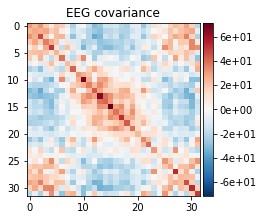

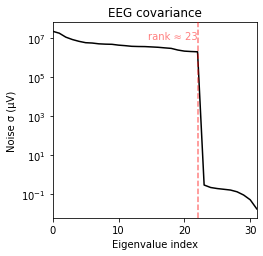

In [12]:
noise_cov = mne.compute_covariance(epochs, tmax=2)

fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, raw.info)

# Inverse operator

In [14]:
from mne.minimum_norm import make_inverse_operator, apply_inverse
from mne.viz import circular_layout
from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_connectivity_circle

In [16]:
inverse_operator = make_inverse_operator(epochs.info, fwd, noise_cov,
                                         loose=0.2, depth=0.8)

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 32 channels.
    32 out of 32 channels remain after picking
Selected 32 channels
Creating the depth weighting matrix...
    32 EEG channels
    limit = 20485/20484 = 2.518446
    scale = 60426.8 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 0.034 (2.2e-16 eps * 32 dim * 4.7e+12  max singular value)
    Estimated rank (eeg): 23
    EEG: rank 23 computed from 32 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD 

In [18]:
method = "dSPM"
snr = 3.
lambda2 = 1. / snr ** 2
stcs = apply_inverse_epochs(epochs, inverse_operator, lambda2, method,
                            pick_ori="normal", return_generator=True)

In [19]:
# Get labels for FreeSurfer 'aparc' cortical parcellation with 34 labels/hemi
labels = mne.read_labels_from_annot('fsaverage', parc='aparc',
                                    subjects_dir=subjects_dir)
labels.pop(-1)
label_colors = [label.color for label in labels]

# Average the source estimates within each label using sign-flips to reduce
# signal cancellations, also here we return a generator
src = inverse_operator['src']
label_ts = mne.extract_label_time_course(
    stcs, labels, src, mode='mean_flip', return_generator=True)

fmin = 8.
fmax = 13.
sfreq = raw.info['sfreq']  # the sampling frequency
con_methods = ['pli', 'wpli2_debiased', 'ciplv']
con = spectral_connectivity_epochs(
    label_ts, method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
    fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)

# con is a 3D array, get the connectivity for the first (and only) freq. band
# for each method
con_res = dict()
for method, c in zip(con_methods, con):
    con_res[method] = c.get_data(output='dense')[:, :, 0]

Reading labels from parcellation...
   read 35 labels from C:\Users\work\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\work\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
Connectivity computation...
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 23 (9 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 32 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 72
Extracting time courses for 68 labels (mode: mean_flip)
only using indices for lower-triangular matrix
    computing connectivity for 2278 connections
    using t=0.000s..2.000s for estimation (513 points)
    frequencies: 8.5Hz..13.0Hz (10 points)
    connectivity sco

Processing epoch : 59 / 72
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 59
Processing epoch : 60 / 72
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 60
Processing epoch : 61 / 72
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 61
Processing epoch : 62 / 72
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 62
Processing epoch : 63 / 72
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 63
Processing epoch : 64 / 72
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 64
Processing epoch : 65 / 72
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 65
Processing epoch : 66 / 72
Extracting time courses for 68 labels (mode: mean_flip)
    computing connectivity for epoch 66
Processing epoch

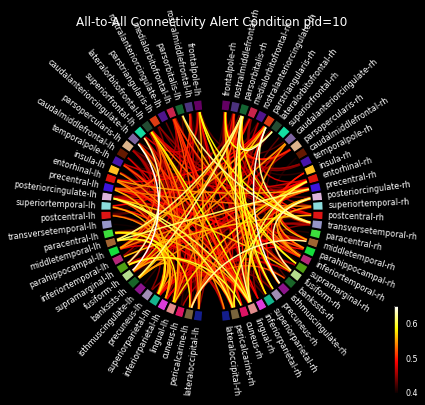

(<Figure size 576x576 with 2 Axes>,
 <PolarAxesSubplot:title={'center':'All-to-All Connectivity Alert Condition pid=10'}>)

In [20]:
# First, we reorder the labels based on their location in the left hemi
label_names = [label.name for label in labels]

lh_labels = [name for name in label_names if name.endswith('lh')]

# Get the y-location of the label
label_ypos = list()
for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(labels[idx].pos[:, 1])
    label_ypos.append(ypos)

# Reorder the labels based on their location
lh_labels = [label for (yp, label) in sorted(zip(label_ypos, lh_labels))]

# For the right hemi
rh_labels = [label[:-2] + 'rh' for label in lh_labels]

# Save the plot order and create a circular layout
node_order = list()
node_order.extend(lh_labels[::-1])  # reverse the order
node_order.extend(rh_labels)

node_angles = circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, len(label_names) / 2])

# Plot the graph using node colors from the FreeSurfer parcellation. We only
# show the 300 strongest connections.
plot_connectivity_circle(con_res['pli'], label_names, n_lines=300,
                         node_angles=node_angles, node_colors=label_colors,
                         title='All-to-All Connectivity Alert Condition pid=10')